### <font color=darkred> [MSA : Modélisation, Apprentissage et Applications] </font>
### <font color = darkblue> <div style="text-align: center"> Projet de fin d'études
## <font color = darkgreen> <div style="text-align: center"> Apprentissage Statistique appliqué à la qualité de vie au travail
### <font color = darkgreen> <div style="text-align: center"> [Smart Building & OZE Energies]
#### <font color = darkblue> <div style="text-align: right"> Binôme : Jordan CHEMOUHOUM, Alaeddine ZEKRI

### Contexte

- La sensation thermique humaine dans un environnement peut être retardée, ce qui peut entraîner des affections mettant la vie en danger, telles que l'hypothermie et l'hyperthermie.
- Celà diffère d'une personne à une autre et peut s'avérer dangereux pour les individus âgés, car le vieillissement modifie la perception thermique.
- Nous envisageons un système d'aide à la décision qui prédit le confort thermique humain en temps réel en utilisant diverses conditions environnementales ainsi que des caractéristiques psychologiques et physiologiques

### Travail attendu

- Nous allons developper un modèle de confort thermique précis en suivant une approche basée sur l'apprentissage automatique pour apprendre ce modèle
- Après l'analyse de données à notre disposition, nous suggérons, grace à notre modèle, les actions correspondantes, qui peuvent améliorer de manière significative le confort thermique général et la santé des personnes, en particulier des personnes âgées.

- **Divers paramètres qui influencent le confort thermique** : 
    - Humidité
    - Taux de CO2
    - Température externe
    - L'age des personnes
    - Type de vêtements portés

In [1]:
#Format des données
import pandas as pd
import numpy as np

#Outils de graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ACP
from sklearn.preprocessing import StandardScaler

#Label Encoder
from sklearn import preprocessing

#Machine Learning tools
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Machine Learning Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
from random import randint

### <font color=darkred> Importation et exploration des données </font>

In [3]:
date = pd.read_csv('Data/confort_sync_data_date.csv')
humidite = pd.read_csv('Data/confort_sync_data_humidite.csv')
humiditex = pd.read_csv('Data/confort_sync_data_humiditex.csv')
tauxCO2 = pd.read_csv('Data/confort_sync_data_tauxCO2.csv')
temperature = pd.read_csv('Data/confort_sync_data_temperature.csv')
score = pd.read_csv('Data/score_comfort.csv')

In [4]:
#on concat les 6 data frame
data = pd.concat([date,humidite,humiditex,tauxCO2,temperature,score],axis=1)

In [5]:
data.columns = ['Date', 'humidite', 'humidite_x', 'tauxCO2', 'Température',
       'label']

In [6]:
data.head()

,Date,humidite,humidite_x,tauxCO2,Température,label
0,31/08/2017 23:00,NaN,25.7,NaN,22.7,4.0
1,31/08/2017 23:30,56.0,25.7,534.0,22.7,4.0
2,31/08/2017 23:50,55.0,25.6,544.0,22.7,4.0
3,01/09/2017 00:00,NaN,25.7,NaN,22.8,5.0
4,01/09/2017 00:30,55.0,25.7,506.0,22.8,4.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
Date           1048575 non-null object
humidite       1048410 non-null float64
humidite_x     1048575 non-null float64
tauxCO2        1048291 non-null float64
Température    1048568 non-null float64
label          1006261 non-null float64
dtypes: float64(5), object(1)
memory usage: 48.0+ MB


In [8]:
#Nombre de NaN pour chaque colonne
data.isnull().sum(axis = 0)

Date               0
humidite         165
humidite_x         0
tauxCO2          284
Température        7
label          42314
dtype: int64

** Nous allons dans un premier temps supprimer les lignes qui contiennent NaN**

In [7]:
data = data.dropna()

In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005983 entries, 1 to 1048574
Data columns (total 6 columns):
Date           1005983 non-null object
humidite       1005983 non-null float64
humidite_x     1005983 non-null float64
tauxCO2        1005983 non-null float64
Température    1005983 non-null float64
label          1005983 non-null float64
dtypes: float64(5), object(1)
memory usage: 53.7+ MB
None


** Nous avons à notre disposition un fichier à 1005983 de lignes**

#### Selecting only 33% of the dataset

We have 1million rows. It's a huge dataset and we dont need that much rows to predict. We are going to keep only 1 row on 3.

In [8]:
data = data.loc[::3,:]

### <font color=darkred> Analyse exploratrice des données

### <font color=darkgreen> Colonne score (les labels) :
- Y a t-il des scores plus redondants que d'autres ? Voyons la distribution des données d'entrainement suivant les scores

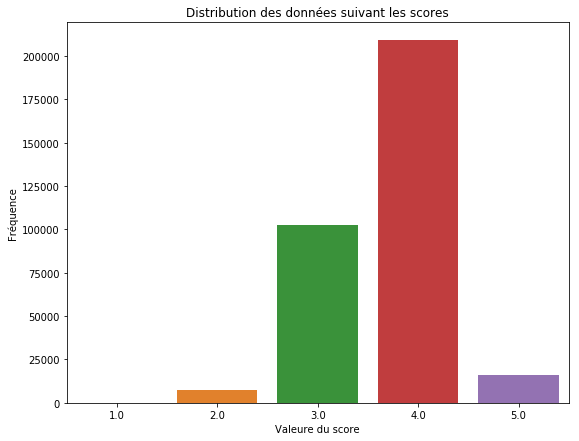

In [48]:
plt.figure(figsize=(9,7))
sns.countplot(x="label", data=data)
plt.ylabel('Fréquence')
plt.xlabel('Valeure du score')
plt.title("Distribution des données suivant les scores")
plt.show()

### <font color=darkgreen> Colonne Humidité :

In [49]:
#description de la colonne Humidité
print(data['humidite'].describe(include='all'))

count    335328.000000
mean         39.536051
std          10.642042
min           0.000000
25%          32.000000
50%          39.000000
75%          47.000000
max          86.000000
Name: humidite, dtype: float64


** Humidité les plus présentes **

In [50]:
#comptage des valeurs de Humidité
data['humidite'].value_counts().head()

35.0    13011
34.0    12950
36.0    12691
37.0    12059
33.0    12000
Name: humidite, dtype: int64

### <font color=darkgreen> Colonne Humidité_X :

In [51]:
#description de la colonne Humidité
print(data['humidite_x'].describe(include='all'))

count    335328.000000
mean         24.629917
std           3.986550
min          -5.600000
25%          22.100000
50%          24.700000
75%          27.400000
max          42.000000
Name: humidite_x, dtype: float64


** Humidité_X les plus présentes **

In [52]:
#comptage des valeurs de Humidité_X
data['humidite_x'].value_counts().head()

24.5    3802
24.2    3798
23.2    3751
23.5    3700
23.6    3692
Name: humidite_x, dtype: int64

### <font color=darkgreen> Colonne TauxCO2 :

In [53]:
#description de la colonne TauxCO2
print(data['tauxCO2'].describe(include='all'))

count    335328.000000
mean        641.363182
std         225.270829
min         252.000000
25%         491.000000
50%         595.000000
75%         744.000000
max        4964.000000
Name: tauxCO2, dtype: float64


** TauxCO2 les plus présentes **

In [54]:
#comptage des valeurs de TauxCO2
data['tauxCO2'].value_counts().head()

511.0    1153
510.0    1145
508.0    1130
506.0    1120
515.0    1109
Name: tauxCO2, dtype: int64

### <font color=darkgreen> Colonne Température :

In [55]:
#description de la colonne Température
print(data['Température'].describe(include='all'))

count    335328.000000
mean         23.700247
std           2.750637
min           0.000000
25%          22.300000
50%          23.800000
75%          25.200000
max          37.400000
Name: Température, dtype: float64


In [56]:
#comptage des valeurs de Température
data['Température'].value_counts().head()

24.7    6662
24.5    6634
24.6    6447
24.8    6322
24.4    6297
Name: Température, dtype: int64

In [57]:
color_list = []
for i in data.loc[:,'label']:
    if i == 1:
        color_list.append('black')
    elif i == 2:
        color_list.append('red')
    elif i == 3: 
        color_list.append('yellow')
    elif i == 4:
        color_list.append('cyan')
    else:
        color_list.append('green')

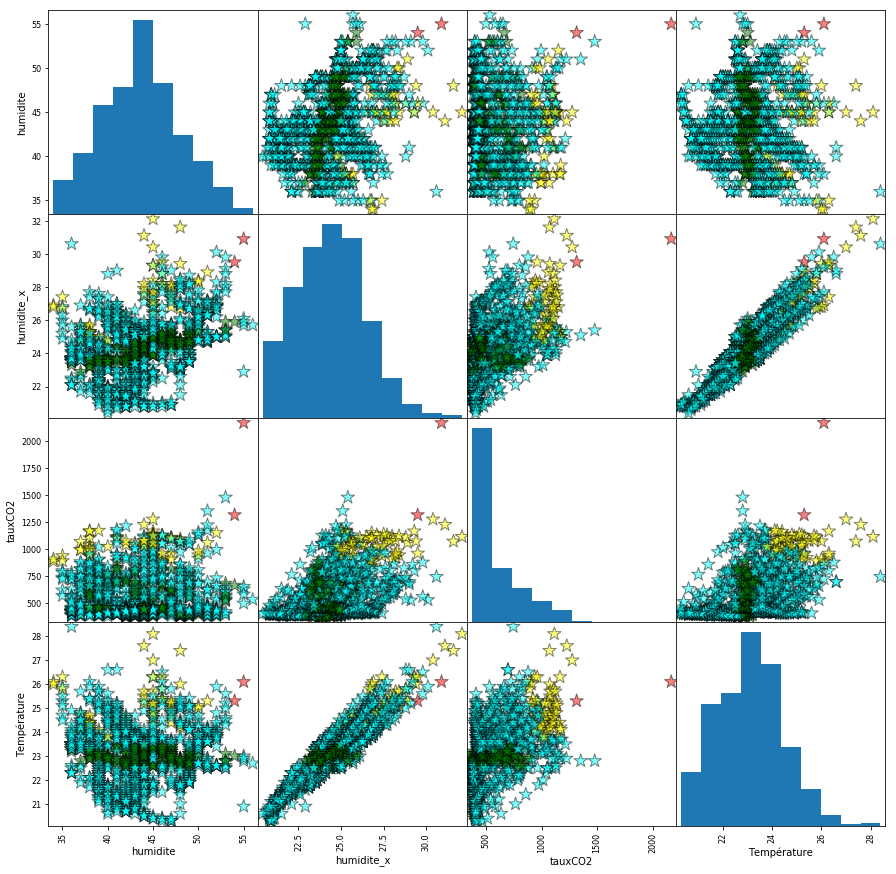

In [102]:
pd.plotting.scatter_matrix(data.loc[:1000,['humidite', 'humidite_x', 'tauxCO2', 'Température','Date']],
                                       c=color_list[:1000],
                                       figsize= [15,15],
                                       diagonal='hist',
                                       alpha=0.5,
                                       s = 200,
                                       marker = '*',
                                       edgecolor= "black")
plt.show()

### <font color=darkred> Traitement de la variable date

### Approche 1
- Utilisation de pd.Timestamp

In [9]:
date2 = data['Date']

In [10]:
date2 = date2.reset_index(drop=True)

In [11]:
date2 = date2.apply(pd.Timestamp)

In [12]:
dates = pd.DataFrame({"year": date2.dt.year,
              "month": date2.dt.month,
              "day": date2.dt.day,
              "hour": date2.dt.hour,
              "dayofyear": date2.dt.dayofyear,
              "week": date2.dt.week,
              "weekofyear": date2.dt.weekofyear,
              "dayofweek": date2.dt.dayofweek,
              "weekday": date2.dt.weekday,
              "quarter": date2.dt.quarter,
             })

In [13]:
columns_to_drop = ['year','day','dayofyear','week','weekofyear','dayofweek','weekday']

In [14]:
dates = dates.drop(columns_to_drop, axis=1)

In [15]:
data = data.reset_index(drop=True)
data = pd.concat([data,dates], axis=1)

In [16]:
data.head()

,Date,humidite,humidite_x,tauxCO2,Température,label,hour,month,quarter
0,31/08/2017 23:30,56.0,25.7,534.0,22.7,4.0,23,8,3
1,01/09/2017 00:50,55.0,25.7,499.0,22.8,4.0,0,1,1
2,01/09/2017 02:30,55.0,26.1,630.0,23.0,4.0,2,1,1
3,01/09/2017 03:50,55.0,25.9,654.0,22.9,4.0,3,1,1
4,01/09/2017 05:50,54.0,25.9,664.0,23.0,5.0,5,1,1


### One Hot Encoding sur <font color=darkred> dates

In [69]:
data_ohe = pd.get_dummies(data,columns=['hour','month','quarter'])
y = data['label']
data_ohe = data_ohe.drop(['Date', 'label'], axis=1)

In [70]:
data_ohe.head()

,humidite,humidite_x,tauxCO2,Température,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,56.0,25.7,534.0,22.7,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,55.0,25.7,499.0,22.8,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,55.0,26.1,630.0,23.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,55.0,25.9,654.0,22.9,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,54.0,25.9,664.0,23.0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### <font color=darkred> Comparaison des modèles de ML

In [ ]:
#Modèles du ML
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SGDClassifier()))
#models.append(('GBC', GradientBoostingClassifier()))
#models.append(('RFC', RandomForestClassifier()))
#models.append(('LDA', LinearDiscriminantAnalysis()))

#Résultats
results = []
names = []
scoring = 'accuracy'

- Approche 1 pour date sans OHE

In [83]:
X1 = data.drop(['label','Date'],axis=1)
y1 = y
#répartition des données en 70% train et 30% test de façon aléatoire
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=32)

#classifier 
classifier = LogisticRegression()

#Entrainement du classifieur
classifier.fit(X_train1, y_train1)

#Prédiction sur X_test1
y_predicted1=classifier.predict(X_test1)

#Evaluation des performances
print('Performances de LogisticRegression')
np.mean(y_predicted1==y_test1)

Performances de LogisticRegression


0.6828795514865953

In [84]:
#classifier 
classifier = KNeighborsClassifier()

#Entrainement du classifieur
classifier.fit(X_train1, y_train1)

#Prédiction sur X_test1
y_predicted1=classifier.predict(X_test1)

#Evaluation des performances
print('Performances de KNeighborsClassifier')
np.mean(y_predicted1==y_test1)

Performances de KNeighborsClassifier


0.8662511555780873

In [85]:
#classifier 
classifier = DecisionTreeClassifier()

#Entrainement du classifieur
classifier.fit(X_train1, y_train1)

#Prédiction sur X_test1
y_predicted1=classifier.predict(X_test1)

#Evaluation des performances
print('Performances de DecisionTreeClassifier')
np.mean(y_predicted1==y_test1)

Performances de DecisionTreeClassifier


0.9995725603634231

- Risque d'Over fitting DecisionTreeClassifier()

In [89]:
#classifier 
classifier = SGDClassifier(loss='hinge',alpha=1e-2,n_iter=5,random_state=42)

#Entrainement du classifieur
classifier.fit(X_train1, y_train1)

#Prédiction sur X_test1
y_predicted1=classifier.predict(X_test1)

#Evaluation des performances
print('Performances de SGDClassifier')
np.mean(y_predicted1==y_test1)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Performances de SGDClassifier


0.6300062624876986

- Approche 1 pour date avec OHE

In [92]:
X2 = data_ohe
y2 = y
#répartition des données en 70% train et 30% test de façon aléatoire
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=32)

#classifier 
classifier = LogisticRegression()

#Entrainement du classifieur
classifier.fit(X_train2, y_train2)

#Prédiction sur X_test1
y_predicted2=classifier.predict(X_test2)

#Evaluation des performances
print('Performances de LogisticRegression')
np.mean(y_predicted2==y_test2)

Performances de LogisticRegression


0.6837244903030846

In [93]:
#classifier 
classifier = KNeighborsClassifier()

#Entrainement du classifieur
classifier.fit(X_train2, y_train2)

#Prédiction sur X_test1
y_predicted2=classifier.predict(X_test2)

#Evaluation des performances
print('Performances de KNeighborsClassifier')
np.mean(y_predicted2==y_test2)

Performances de KNeighborsClassifier


0.9113311265519538

In [194]:
#classifier 
classifier = DecisionTreeClassifier()

#Entrainement du classifieur
classifier.fit(X_train2, y_train2)

#Prédiction sur X_test1
y_predicted2=classifier.predict(X_test2)

#Evaluation des performances
print('Performances de DecisionTreeClassifier')
np.mean(y_predicted2==y_test2)

Performances de DecisionTreeClassifier


0.9995825008200877

In [95]:
#classifier 
classifier = SGDClassifier(loss='hinge',alpha=1e-2,n_iter=5,random_state=42)

#Entrainement du classifieur
classifier.fit(X_train2, y_train2)

#Prédiction sur X_test1
y_predicted2=classifier.predict(X_test2)

#Evaluation des performances
print('Performances de SGDClassifier')
np.mean(y_predicted1==y_test2)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Performances de SGDClassifier


0.6839928826330282

### Test de l'Over Fitting 

- Nous évaluons notre model supposé Over fitté sur une partie des données tirée au hasard parmis les 2/3 de data que nous avons pas pris pour la phase d'entrainement

In [181]:
data_test = pd.concat([date,humidite,humiditex,tauxCO2,temperature,score],axis=1)

In [182]:
import random
u = random.sample(range(1005983),30000)
v = set(u) - set(X_train2.index)
data_test = data_test.loc[v,:]

In [183]:
data_test.columns = ['Date', 'humidite', 'humidite_x', 'tauxCO2', 'Température',
       'label']

In [184]:
data_test = data_test.dropna()

In [185]:
date3 = data_test['Date']

In [186]:
date3 = date3.reset_index(drop=True)

In [187]:
date3 = date3.apply(pd.Timestamp)

In [188]:
dates3 = pd.DataFrame({"year": date3.dt.year,
              "month": date3.dt.month,
              "day": date3.dt.day,
              "hour": date3.dt.hour,
              "dayofyear": date3.dt.dayofyear,
              "week": date3.dt.week,
              "weekofyear": date3.dt.weekofyear,
              "dayofweek": date3.dt.dayofweek,
              "weekday": date3.dt.weekday,
              "quarter": date3.dt.quarter,
             })

In [189]:
columns_to_drop = ['year','day','dayofyear','week','weekofyear','dayofweek','weekday']

In [190]:
dates3 = dates3.drop(columns_to_drop, axis=1)

In [191]:
data_test = data_test.reset_index(drop=True)
data_test = pd.concat([data_test,dates3], axis=1)

In [192]:
data_test_ohe = pd.get_dummies(data_test,columns=['hour','month','quarter'])
y_test = data_test['label']
data_test_ohe = data_test_ohe.drop(['Date', 'label'], axis=1)

In [195]:
y_test_predicted=classifier.predict(data_test_ohe)
np.mean(y_test_predicted==y_test)

0.9999095513748191

- Le modèle semble toujours Over fitté

### Approche 2
- Nous définissons 3 plages horaires que nous pensons être importantes :
    - Heures de travail : 8h-->18h
    - Heures de préchauffage et de mise en veille : 5h-->8h et 18h-->20h
    - Heures de non travail / soir : 20h -->5h

In [36]:
data['h_travail'] = [0 for i in range(len(data['hour']))]
data['h_soir'] = [0 for i in range(len(data['hour']))]
data['h_maintain'] = [0 for i in range(len(data['hour']))]

s = data.hour.apply(lambda x : x in range(8,19))
s = s.apply(lambda x : int(x))
data.h_travail = s

s = data.hour.apply(lambda x : x in [21,22,23,0,1,2,3,4])
s = s.apply(lambda x : int(x))
data.h_soir = s

s = data.hour.apply(lambda x : x in [5,6,7,19,20])
s = s.apply(lambda x : int(x))
data.h_maintain = s

data = data.drop(['hour'], axis=1)

In [37]:
data.head()

,Date,humidite,humidite_x,tauxCO2,Température,label,month,quarter,h_travail,h_soir,h_maintain
0,31/08/2017 23:30,56.0,25.7,534.0,22.7,4.0,8,3,0,1,0
1,01/09/2017 00:50,55.0,25.7,499.0,22.8,4.0,1,1,0,1,0
2,01/09/2017 02:30,55.0,26.1,630.0,23.0,4.0,1,1,0,1,0
3,01/09/2017 03:50,55.0,25.9,654.0,22.9,4.0,1,1,0,1,0
4,01/09/2017 05:50,54.0,25.9,664.0,23.0,5.0,1,1,0,0,1


In [42]:
X3 = data.drop(['label','Date'],axis=1)
y3 = data.label
#répartition des données en 70% train et 30% test de façon aléatoire
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=32)

In [43]:
#classifier 
classifier = LogisticRegression()

#Entrainement du classifieur
classifier.fit(X_train3, y_train3)

#Prédiction sur X_test1
y_predicted3=classifier.predict(X_test3)

#Evaluation des performances
print('Performances de LogisticRegression : h_travail - h_soir - h_maintain')
np.mean(y_predicted3==y_test3)

Performances de LogisticRegression : h_travail - h_soir - h_maintain


0.6833169315798368

In [44]:
#classifier 
classifier = KNeighborsClassifier()

#Entrainement du classifieur
classifier.fit(X_train3, y_train3)

#Prédiction sur X_test1
y_predicted3=classifier.predict(X_test3)

#Evaluation des performances
print('Performances de KNeighborsClassifier : h_travail - h_soir - h_maintain')
np.mean(y_predicted3==y_test3)

Performances de KNeighborsClassifier : h_travail - h_soir - h_maintain


0.897931390968101

In [45]:
#classifier 
classifier = DecisionTreeClassifier()

#Entrainement du classifieur
classifier.fit(X_train3, y_train3)

#Prédiction sur X_test1
y_predicted3=classifier.predict(X_test3)

#Evaluation des performances
print('Performances de DecisionTreeClassifier : h_travail - h_soir - h_maintain')
np.mean(y_predicted3==y_test3)

Performances de DecisionTreeClassifier : h_travail - h_soir - h_maintain


0.999552679450094

In [46]:
#classifier 
classifier = SGDClassifier(loss='hinge',alpha=1e-2,n_iter=5,random_state=42)

#Entrainement du classifieur
classifier.fit(X_train3, y_train3)

#Prédiction sur X_test1
y_predicted3=classifier.predict(X_test3)

#Evaluation des performances
print('Performances de SVM : h_travail - h_soir - h_maintain')
np.mean(y_predicted3==y_test3)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Performances de SVM : h_travail - h_soir - h_maintain


0.6327895903537809